In [1]:
import sys
sys.path.append("../")
from enhancer import *
from enhancer.inference import *
from enhancer.utils import *
from enhancer.options import *
import copy
# device = torch.device("cpu")
%load_ext autoreload
%autoreload 2

In [2]:
opt_path = "../configs/smallmodel/gan_train.yml"
generator= get_generator_from_yml(opt_path,False)

generator is loaded from /notebooks/pixelEnhancer/checkpoints/verysmall_best_charbonnier_x4_imdn_rtc_20_6.pt


In [5]:
start=time.time()
print(generator.to(device)(torch.randn(1,3,960,540).to(device)).shape)
time.time()-start

torch.Size([1, 3, 3840, 2160])


0.02523636817932129

In [3]:
def preds(arr,filename=None,denormalize=False):
    arr.clamp_(0,1)
    a = im_convert(arr[0],denormalize=denormalize)
    im = Image.fromarray(np.uint8(a*255))
    if filename:
        plt.imsave(filename+'.png', a)
    return im


In [10]:
def predict_without_patch(filename,scale=4,resize=True):
    bicubic = None
    if type(filename) == type(""):
        ex = Image.open(filename).convert("RGB")
    else:
        ex = filename.copy()
        filename = "sample.png"
        ex_img = ex.copy()
    if resize:
        ex= ex.resize((ex.size[0]//scale,ex.size[1]//scale))
        bicubic = ex.resize((ex.size[0]*scale,ex.size[1]*scale),resample = Image.BICUBIC)
        ex_img = ex.copy()
    ex = np.array(ex).transpose(2,0,1)/255.
    ex = torch.from_numpy(ex).unsqueeze(0).float().to(device)
    with torch.no_grad():
        generator.eval()
        start=time.time()
        result = generator(ex)
        print(time.time()-start)
    img = preds(result)
    if resize ==False:
        bicubic = ex_img.resize((ex_img.size[0]//scale,ex_img.size[1]//scale))
    return img,ex_img,bicubic



In [8]:
def predict_with_patch(img,generator=generator):
    try:
        img_splitter = ImageSplitter(seg_size=150, scale_factor=4, boarder_pad_size=1)
        img_patches = img_splitter.split_img_tensor(img, scale_method=None, img_pad=0)
        out=[]
        with torch.no_grad():
          for j,i in enumerate(tqdm(img_patches)):
            # print(j)
            with torch.no_grad():
                generator.eval()
                out.append(generator(i.to(device)))
        img_upscale = img_splitter.merge_img_tensor(out)
        a=preds(img_upscale)
        return a
    except Exception as e:
        print(str(e))

In [6]:
import requests
from io import  BytesIO
response = requests.get("https://images.unsplash.com/photo-1594230612513-24c4ca53e781?ixlib=rb-1.2.1&auto=format&fit=crop&w=1050&q=80")
img = Image.open(BytesIO(response.content))

In [9]:
!ls

Photo-1.jpeg		       sample.png.png
WIN_20201204_19_46_21_Pro.jpg  singlebatchoverfit.ipynb
inference.ipynb		       train_bigmodel.ipynb
lr-finder.ipynb		       train_smallmodel_mse.ipynb


In [7]:
img =  Image.open("Photo-1.jpeg").convert("RGB")
generator.to(device)
generator.load_state_dict(torch.load("../checkpoints/verysmall_best_charbonnier_x4_imdn_rtc_20_6.pt",map_location=device)["generator_state_dict"])
import time
start=time.time()
result,input_img,bicubic = predict_without_patch(img,resize=True,scale=4)
print(time.time()-start) 

0.015755176544189453
0.7882339954376221


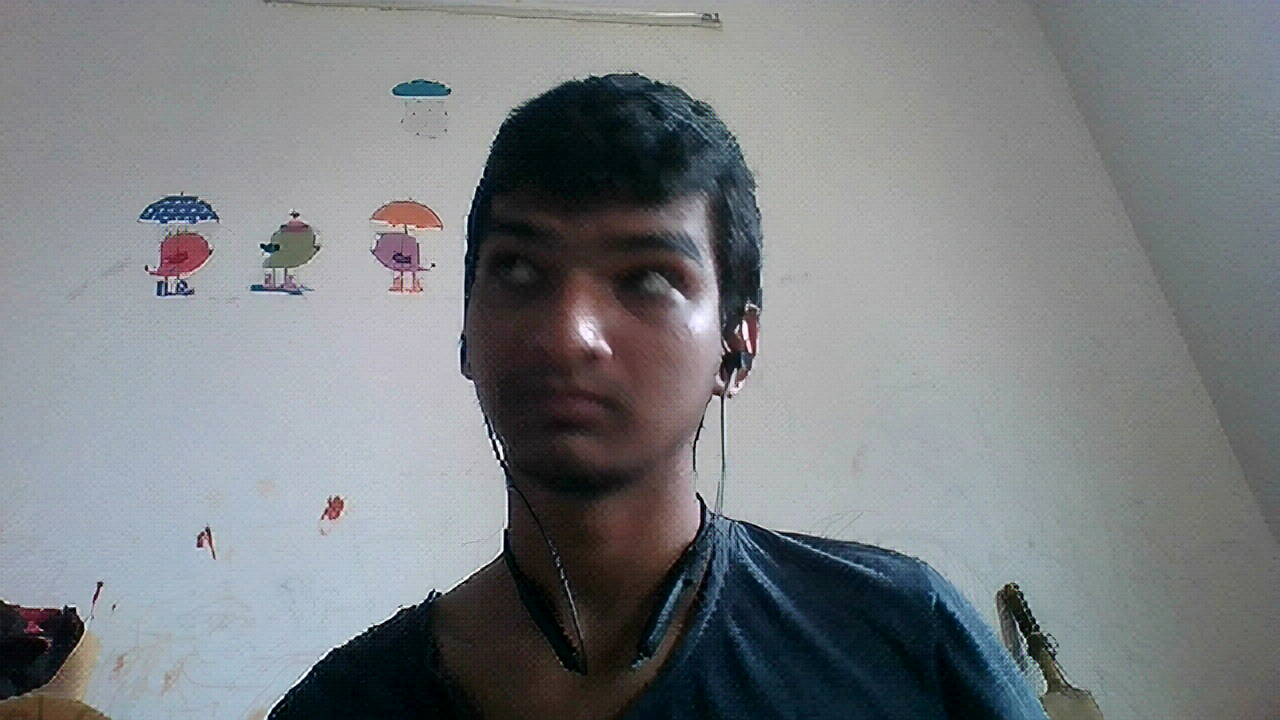

In [10]:
result

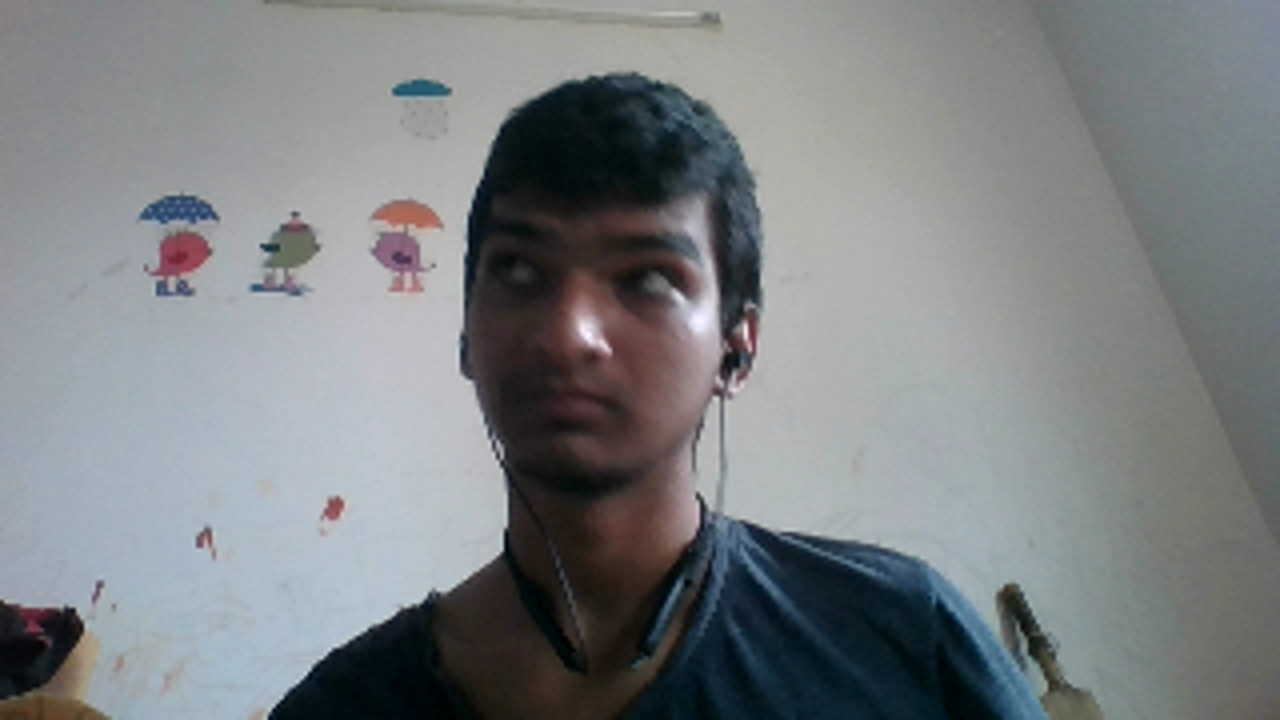

In [14]:
bicubic

In [ ]:
result=predict_without_patch(img.resize((img.size[0]//10,img.size[1]//10)),resize=False)


In [104]:
generator.load_state_dict(torch.load("../checkpoints/verysmall_best_charbonnier_x4_imdn_rtc_20_6.pt",map_location=device)["generator_state_dict"])

result=predict_without_patch(img.resize((img.size[0]//10,img.size[1]//10)),resize=False)


0.0053005218505859375


In [106]:

predict_with_patch(img.resize((img.size[0]//4,img.size[1]//4)),generator).save("test1.png")

100%|██████████| 2/2 [00:00<00:00, 35.31it/s]
